In [1]:
using PureSeq
using PerformanceEval

In [2]:
function contig_index_map(contigs)
    indexMap = Dict{ASCIIString,Int64}()
    count = 0
    for name in contigs.names
        count += 1
        indexMap[name] = count
    end
    indexMap 
end

contig_index_map (generic function with 1 method)

In [3]:
type ChromosomePosition
    chr::ASCIIString
    pos::Int64
    value::Float64
end

function read_peaks(f, format, contigs)
    indexMap = contig_index_map(contigs)
    positions = (Int64,Float64)[]
    for line in eachline(f)
        parts = split(line)
        if parts[1][1] == '#' continue end
        
        if format == "narrowPeak"
            chr = parts[1]
            pos = int(parts[2])
            value = float(parts[8])
        elseif format == "FIMO"
            chr = parts[2]
            pos = int((int(parts[3])+int(parts[4]))/2)
            value = float(parts[6])
        elseif format == "bed2"
            chr = parts[1]
            pos = int((int(parts[2])+int(parts[3]))/2)
            value = float(parts[4])
        elseif format == "bed"
            chr = parts[1]
            pos = int((int(parts[2])+int(parts[3]))/2)
            value = float(parts[5])
        end
        
        push!(positions, (pos + contigs.offsets[indexMap[chr]], value))
    end
    sort!(positions, by=x->x[1])
end

root = "/scratch2/slund1/ENCSR000BQS_notebook"
shredRoot = "/projects/leelab/data/pure-seq"

peaks = open(f->read_peaks(f, "bed", ReferenceContigs_hg38), "$root/ENCFF000NYK_matched_ENCFF000ODO_q5_summits.bed")
motifs = open(f->read_peaks(f, "FIMO", ReferenceContigs_hg38), "$shredRoot/REST_MA0138.2_FIMO_p6.txt")

function find_distance(position, positions)
    minDist = 100000000
    for i in 1:length(positions)
        if abs(position[1] - positions[i][1]) < minDist
            minDist = abs(position[1] - positions[i][1])
        end
    end
    minDist
end

find_distance (generic function with 1 method)

In [4]:
function get_bins_at_peaks(peaks, binnedFile; contextBefore=0, contextAfter=0)
    br = BinnedReader(binnedFile)
    bufSize = contextBefore+contextAfter+1
    bufferPositions = zeros(Float32, bufSize)
    bufferValues = zeros(Float32, bufSize)
    bufPos = 0
    
    out = Float32[]
    for (pos,val) in peaks
        binPos = floor((pos-1)/100) + 1
        while !eof(br) && position(br) <= binPos+contextAfter
            bufferValues[bufPos+1] = value(br)
            bufferPositions[bufPos+1] = position(br)
            bufPos = (bufPos+1)%bufSize
            advance!(br)
        end

        # extract all the counts in the buffer that fall in our window
        total = float32(0.0)
        for i in 1:bufSize
            if bufferPositions[i] >= binPos-contextBefore
                total += bufferValues[i]
            end
        end
        push!(out, total)
    end
    out
end

get_bins_at_peaks (generic function with 1 method)

<h3>Try our hand at direct peak prediction</h3>

In [13]:
# load the predicted background
predf = GZip.open(readdlm, "/scratch2/slund1/pure-seq/forwardReads_c35_b4_a4.490.pred.gz")
predr = GZip.open(readdlm, "/scratch2/slund1/pure-seq/reverseReads_c35_b4_a4.370.pred.gz")
backgroundPred = vec(predf[1:32000000] .+ predr[1:32000000])
maximum(backgroundPred)

76.59814899999999

In [21]:
# load the predicted target
predf = open(readdlm, "/scratch2/slund1/pure-seq/forwardReads_SVD_REST.pred")
predr = open(readdlm, "/scratch2/slund1/pure-seq/reverseReads_SVD_REST.pred")
targetPred = -vec(predf[1:32000000] .+ predr[1:32000000])
maximum(targetPred)

0.7109612790732321

In [12]:
minimum(targetPred),maximum(targetPred)

(-1.588772008521316e-14,0.7109612790732321)

In [9]:
# load the predicted target
predf = GZip.open(readdlm, "/scratch2/slund1/pure-seq/forwardReads_cREST-NYK_b4_a4.800.pred.gz")
predr = GZip.open(readdlm, "/scratch2/slund1/pure-seq/reverseReads_cREST-NYK_b4_a4.800.pred.gz")
targetPred = vec(predf[1:32000000] .+ predr[1:32000000])
maximum(targetPred)

158.8417

In [18]:
# mark which bins have motifs in them
motifBins = zeros(32000000)
for i in 1:length(motifs)
    pos = floor((motifs[i][1]-1)/100)+1
    if pos <= length(motifBins)
        motifBins[pos] = 1
    end
end

In [49]:
# load the target data
function read_bin_data(fileName)
    reader = BinnedReader(fileName)
    out = (Uint32,Uint32)[]
    while !eof(reader)
        push!(out, (position(reader), value(reader)))
        advance!(reader)
    end
    close(reader)
    out
end
dataf = read_bin_data("/scratch2/slund1/pure-seq/binned_data/ENCFF000NYK.bam.fbin100")
datar = read_bin_data("/scratch2/slund1/pure-seq/binned_data/ENCFF000NYK.bam.rbin100")
targetBins = zeros(size(pred))
for i in 1:length(dataf)
    if dataf[i][1] <= length(targetBins)
        targetBins[dataf[i][1]] += dataf[i][2]
    end
end
for i in 1:length(datar)
    if datar[i][1] <= length(targetBins)
        targetBins[datar[i][1]] += datar[i][2]
    end
end

In [6]:
using Distributions

In [16]:
# compute scores at every position
scores = zeros(length(targetPred))
for i in 1:length(targetPred)
    scores[i] = targetPred[i]/backgroundPred[i]
    #scores[i] = ccdf(Poisson(pred[i]), targetBins[i])
end

In [68]:
# compute scores at every position
scores2 = zeros(length(targetPred))
for i in 1:length(targetPred)
    #scores2[i] = targetBins[i]/backgroundPred[i]
    scores2[i] = ccdf(Poisson(backgroundPred[i]), targetBins[i])
end

In [173]:
scores2 = zeros(length(pred))
d = Poisson(mean(pred))
for i in 1:length(pred)
    scores2[i] = ccdf(d, targetBins[i])
end

In [180]:
binOrder2 = sortperm(scores2[1:2000000]);

In [22]:
scores = targetPred;

In [23]:
binOrder = sortperm(scores, alg=MergeSort)
reverse!(binOrder)
scores[binOrder[end-10:end]]

11-element Array{Float64,1}:
 -0.0        
 -0.0        
 -0.0        
 -0.0        
 -0.0        
 -0.0        
 -0.0        
 -0.0        
 -0.0        
 -0.0        
 -1.58877e-14

In [18]:
writedlm("data/scoresTmp.txt", scores)

In [10]:
scores = vec(readdlm("data/scoresTmp.txt"));

In [9]:
Out[7] = nothing

In [69]:
binOrder2 = sortperm(scores2)
scores2[binOrder2[end-10:end]]

11-element Array{Float64,1}:
 0.999996
 0.999997
 0.999997
 0.999999
 0.999999
 1.0     
 1.0     
 1.0     
 1.0     
 1.0     
 1.0     

In [68]:
sum(motifBins[binOrder[1:100]])/100

0.84

In [149]:
using KDTrees

In [14]:
function find_min_dist(el, list)
    minDist = 100000.0
    for i in 1:length(list)
        minDist = min(minDist, abs(list[i] - el))
    end
    minDist
end

find_min_dist (generic function with 1 method)

In [15]:
predictedPeakBins = (Int64,Float64)[]
#tree = KDTree(predictedPeakBins)
seenPeaks = Int64[]
for (i,ind) in enumerate(binOrder[1:10000])
    
    if find_min_dist(ind, seenPeaks) > 10
        push!(predictedPeakBins, (ind, sum(scores[ind-2:ind+2])))
        #push!(predictedPeakBins, (ind, scores[ind]))
        #push!(predictedPeakBins, (ind, sum(log(scores[ind-1:ind+1]))))
        push!(seenPeaks, ind)
    end
end
predictedPeakBins = map(x->x[1], sort(predictedPeakBins, by=x->-x[2]));

In [107]:
predictedPeakBins2 = (Int64,Float64)[]
#tree = KDTree(predictedPeakBins)
seenPeaks = Int64[]
for (i,ind) in enumerate(binOrder2[1:10000])
    
    if find_min_dist(ind, seenPeaks) > 10
        #push!(predictedPeakBins2, (ind, sum(scores2[ind-2:ind+2])))
        #push!(predictedPeakBins, (ind, scores[ind]))
        push!(predictedPeakBins2, (ind, sum(log(scores[ind-1:ind+1]))))
        push!(seenPeaks, ind)
    end
end
predictedPeakBins2 = map(x->x[1], sort(predictedPeakBins2, by=x->x[2]));

In [109]:
length(predictedPeakBins2)

3578

In [110]:
predictedPeakBinsFiltered = filter(x->find_min_dist(x, predictedPeakBins) < 5, predictedPeakBins2)
length(predictedPeakBinsFiltered)

1263

In [16]:
length(predictedPeakBins)

6168

In [20]:
numTests = 6100
offset = 0
totalMatches = 0
results = zeros(numTests)
for (i,ind) in enumerate(predictedPeakBins[1+offset:offset+numTests])
    if sum(motifBins[ind-4:ind+4]) > 0
        results[i] = 1
        totalMatches += 1
    end
end
totalMatches/numTests,totalMatches

(0.3344262295081967,2040)

In [211]:
results[61:80]

20-element Array{Float64,1}:
 1.0
 1.0
 0.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 0.0
 1.0
 1.0
 1.0
 1.0
 1.0

In [225]:
testInd = 63
println("True answer: ", results[testInd])
res = int(show_context_at((predictedPeakBins[testInd]-1)*100+1, targetId, controlIds35[1:5], useReverseReads=true, contextWidth=10))

True answer: 0.0


21x6 Array{Int64,2}:
   2  0  3   0  2  3
   0  1  0   0  0  2
   0  1  1   3  0  3
   0  0  0   0  0  0
   0  0  4   0  0  0
   0  0  3   0  0  0
   0  0  2   0  1  0
   3  1  0   0  0  0
   1  1  0   2  5  2
   5  0  0   0  4  0
  52  1  6  11  9  0
 219  2  2   5  3  0
  22  1  5   1  0  1
   1  2  3   0  0  1
   0  0  2   1  1  1
   4  0  0   0  0  1
   0  0  0   1  1  2
   0  0  0   0  0  1
   0  0  0   1  0  0
   0  0  0   0  0  2
   0  0  1   1  1  0

In [38]:
using Gadfly

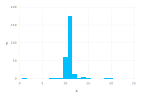

In [219]:
plot(x=1:21, y=res[:,1], Geom.bar)

In [228]:
res[:,4]

21-element Array{Int64,1}:
  0
  0
  3
  0
  0
  0
  0
  0
  2
  0
 11
  5
  1
  0
  1
  0
  1
  0
  1
  0
  1

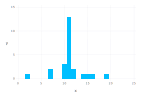

In [220]:
plot(x=1:21, y=res[:,4], Geom.bar)

In [95]:
find_min_dist(377645, binOrder[2:100])

28395.0

In [89]:
binOrder[1:100]

100-element Array{Int64,1}:
   377645
  1107469
  1591775
  3718685
  4491756
  4491757
  5180080
  5294416
 10253145
 11894740
 12373467
 12454096
 12839992
        ⋮
 28792265
 10660827
 15728233
    62453
 17645716
 15717579
 23779425
  2048377
  4579684
   418107
 15112455
 23017767

In [50]:
writedlm("/tmp/results3.txt", results)

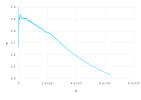

In [67]:
xs,ys = rank_precision(results)
plot(x=xs,y=ys,Geom.line)

In [66]:
sum(motifBins)/length(motifBins)

0.0009021900192973873

In [5]:
targetId = "ENCFF000NYK"
controlIds35 = [
    "ENCFF000ODO", # designated control
    "ENCFF000ODV", # another GM12878 control (rep1)
    "ENCFF000ODZ", # another GM12878 control (rep2)
    "ENCFF000OEB", # another GM12878 control (rep3)
    "ENCFF000NGK",
    "ENCFF000NGM",
    "ENCFF000NGN",
    "ENCFF000QET",
    "ENCFF000QEU",
    "ENCFF000QFL",
    "ENCFF000QFS",
    "ENCFF000RCB",
    "ENCFF000RCC",
    "ENCFF000RCF",
    "ENCFF000RPT",
    "ENCFF000SAZ",
    "ENCFF000VPI",
    "ENCFF000VPK",
    "ENCFF000WIQ",
    "ENCFF000WIX",
    "ENCFF000WPT",
    "ENCFF000WPV",
    "ENCFF000XOO",
    "ENCFF000XRH",
    "ENCFF000XRI",
    "ENCFF000XTE",
    "ENCFF000YPF",
    "ENCFF000YPM",
    "ENCFF000YRC",
    "ENCFF000YRN",
    "ENCFF000ZSI",
    "ENCFF000ZVJ",
    "ENCFF000ZVV",
    "ENCFF001HAV",
    "ENCFF001HGV"
];

In [6]:
function build_peak_data_matrix(targetId, controlIds, peaks; useReverseReads=false, contextBefore=0, contextAfter=0)
    suffix = useReverseReads ? "rbin100" : "fbin100"
    y = get_bins_at_peaks(peaks, "$root/$targetId.bam.$suffix", contextBefore=contextBefore, contextAfter=contextAfter)
    
    X = zeros(Float32, length(peaks), length(controlIds))
    for i in 1:length(controlIds)
        X[:,i] = get_bins_at_peaks(peaks, "$root/$(controlIds[i]).bam.$suffix", contextBefore=contextBefore, contextAfter=contextAfter)
    end
    
    y,X
end

build_peak_data_matrix (generic function with 1 method)

In [7]:
# y,X = build_peak_data_matrix(targetId, ["ENCFF000ODO"], peaks[1:20]; useReverseReads=false, contextSize=0)
# d = [find_distance(peaks[i], motifs) for i in 1:20]
# s = [peaks[i][2] for i in 1:20]
# p = [peaks[i][1] for i in 1:20]
# [p s d y X]

In [8]:
function get_bin_values(positions, binnedFile)
    br = BinnedReader(binnedFile)
    
    out = Float32[]
    for binPos in positions
        while !eof(br) && position(br) < binPos
            advance!(br)
        end
        if position(br) == binPos
            push!(out, value(br))
        else
            push!(out, 0)
        end
    end
    out
end

get_bin_values (generic function with 1 method)

In [9]:
function show_context_at(pos, targetId, controlIds; useReverseReads=false, contextWidth=6)
    suffix = useReverseReads ? "rbin100" : "fbin100"
    binPos = floor((pos-1)/100) + 1
    context = binPos-contextWidth:binPos+contextWidth
    y = get_bin_values(context, "$root/$targetId.bam.$suffix")
    
    X = zeros(Float32, length(context), length(controlIds))
    for i in 1:length(controlIds)
        X[:,i] = get_bin_values(context, "$root/$(controlIds[i]).bam.$suffix")
    end
    
    [y X]
end

show_context_at (generic function with 1 method)

In [188]:
int(show_context_at(1300575, targetId, controlIds35[1:16], useReverseReads=true))

13x17 Array{Int64,2}:
 3  1  0  2  2  1  1  2  0  0  0  4  0  2  0  0  0
 0  0  2  0  9  0  0  2  1  0  0  9  0  0  0  0  1
 4  1  0  3  2  0  2  0  0  2  1  9  0  0  0  0  2
 3  1  0  1  4  0  1  0  1  0  0  9  0  0  0  0  1
 2  0  0  2  4  0  1  2  0  0  0  4  1  1  0  0  1
 2  0  1  1  1  1  1  0  1  0  0  4  1  1  0  0  0
 4  1  0  0  2  1  2  1  3  1  1  4  0  1  0  0  1
 2  0  2  0  4  0  1  1  0  2  2  7  0  1  0  0  2
 0  0  0  0  3  0  1  1  1  0  0  5  1  3  0  0  0
 1  0  0  2  3  1  1  2  1  0  0  3  1  2  1  0  1
 0  0  0  1  2  0  0  0  1  0  0  4  0  3  0  1  1
 2  1  0  0  3  0  1  0  0  0  0  6  0  0  0  1  0
 1  0  0  2  1  1  0  2  0  0  0  4  1  0  1  0  2

In [19]:
int(show_context_at(1213007, targetId, controlIds35[1:16], useReverseReads=false, contextWidth=2))

5x17 Array{Int64,2}:
  4  0  1  1  11  0  0  0  0  0  0   9  0  0  0  0  0
 11  3  0  3  10  0  0  0  0  0  0  11  1  0  0  0  1
  5  0  0  1   6  0  1  0  0  0  0   2  1  0  0  0  1
  2  1  0  0   7  0  0  0  0  0  0   7  1  2  0  0  1
  0  1  0  2   9  0  0  0  0  0  0   6  0  1  0  0  0

In [12]:
int(show_context_at(1213007, targetId, controlIds35[1:16], useReverseReads=true, contextWidth=2))

5x17 Array{Int64,2}:
  0  0  0  1   5  0  0  1  0  0  0  5  0  2  0  0  0
  9  0  0  2  10  0  1  0  0  2  1  5  0  1  0  0  2
 10  0  2  3   9  0  1  1  0  0  0  8  0  1  0  0  0
  2  0  0  3   7  1  1  0  0  0  0  2  1  0  0  0  1
  2  1  2  2  11  0  0  0  0  0  0  6  0  0  0  0  0

In [13]:
# yr1b,Xr1b = build_peak_data_matrix(targetId, controlIds35[1:35], peaks; useReverseReads=true, contextBefore=1)
# yf1b,Xf1b = build_peak_data_matrix(targetId, controlIds35[1:35], peaks; useReverseReads=false, contextBefore=1)
# yr1a,Xr1a = build_peak_data_matrix(targetId, controlIds35[1:35], peaks; useReverseReads=true, contextAfter=1)
# yf1a,Xf1a = build_peak_data_matrix(targetId, controlIds35[1:35], peaks; useReverseReads=false, contextAfter=1)

# yr4b,Xr4b = build_peak_data_matrix(targetId, controlIds35[1:35], peaks; useReverseReads=true, contextBefore=4)
# yf4b,Xf4b = build_peak_data_matrix(targetId, controlIds35[1:35], peaks; useReverseReads=false, contextBefore=4)
# yr4a,Xr4a = build_peak_data_matrix(targetId, controlIds35[1:35], peaks; useReverseReads=true, contextAfter=4)
# yf4a,Xf4a = build_peak_data_matrix(targetId, controlIds35[1:35], peaks; useReverseReads=false, contextAfter=4)

# yr10b,Xr10b = build_peak_data_matrix(targetId, controlIds35[1:35], peaks; useReverseReads=true, contextBefore=10)
# yf10b,Xf10b = build_peak_data_matrix(targetId, controlIds35[1:35], peaks; useReverseReads=false, contextBefore=10)
# yr10a,Xr10a = build_peak_data_matrix(targetId, controlIds35[1:35], peaks; useReverseReads=true, contextAfter=10)
# yf10a,Xf10a = build_peak_data_matrix(targetId, controlIds35[1:35], peaks; useReverseReads=false, contextAfter=10)

yr4,Xr4 = build_peak_data_matrix(targetId, controlIds35[1:35], peaks; useReverseReads=true, contextBefore=10, contextAfter=10)
yf4,Xf4 = build_peak_data_matrix(targetId, controlIds35[1:35], peaks; useReverseReads=false, contextBefore=10, contextAfter=10)
#yr10,Xr10 = build_peak_data_matrix(targetId, controlIds35[1:35], peaks; useReverseReads=true, contextSize=10)
#yf10,Xf10 = build_peak_data_matrix(targetId, controlIds35[1:35], peaks; useReverseReads=false, contextSize=10)
#D = [yr1b yf1b Xr1b Xf1b yr1a yf1a Xr1a Xf1a yr4b yf4b Xr4b Xf4b yr4a yf4a Xr4a Xf4a yr10b yf10b Xr10b Xf10b yr10a yf10a Xr10a Xf10a];
D = [yr4 yf4 Xr4 Xf4]
open(f->write(f, D), "/tmp/D3_q5.cache", "w")

7480224

In [30]:
X = [Xr Xf]
y = yr + yf;

In [13]:
D = zeros(Float32, length(peaks), 2*(length(controlIds35)+1))
open(f->read!(f, D), "/tmp/D.cache")

9594x72 Array{Float32,2}:
  55.0   39.0     5.0     8.0  …     8.0    6.0     6.0    3.0    4.0
  38.0   47.0     4.0     8.0        8.0    2.0     2.0    5.0    5.0
  67.0   29.0     5.0    11.0        9.0    3.0     7.0    6.0    3.0
  67.0   81.0     3.0     7.0        8.0    3.0     9.0    6.0    3.0
  60.0   46.0     2.0     5.0       12.0    1.0     2.0    2.0    5.0
 698.0  753.0  2179.0  2831.0  …  1888.0  417.0  2096.0  256.0  645.0
 635.0  654.0  2690.0  3698.0     1077.0  676.0  2674.0  254.0  731.0
 693.0  782.0  2674.0  3535.0     1927.0  569.0  2301.0  240.0  804.0
 793.0  746.0  2737.0  3485.0     1806.0  542.0  2346.0  256.0  731.0
  80.0  106.0     3.0     7.0        5.0    8.0    10.0    4.0    5.0
  44.0   38.0     3.0     8.0  …    14.0    1.0     9.0    2.0    4.0
  16.0   15.0    10.0    15.0       20.0    3.0    11.0    3.0   12.0
  23.0   24.0     2.0     5.0       12.0    2.0     0.0    2.0    5.0
   ⋮                           ⋱                           ⋮    

In [22]:
using GLMNet

In [14]:
d = [find_distance(peaks[i], motifs) for i in 1:length(peaks)]
s = [peaks[i][2] for i in 1:length(peaks)]
topLabel = [[ones(2000), zeros(length(peaks)-2000)] [zeros(2000), ones(length(peaks)-2000)]]
trueLabel = [int(d .<= 500) int(d .> 500)];

In [15]:
length(peaks)

25973

In [23]:
trainSize = 15000
srand(1)
inds = shuffle(collect(1:length(peaks)))
trainD = D[inds[1:trainSize],:]
# trainX = X[inds[1:5000],:]
# trainy = y[inds[1:5000]]
trainLabel = trueLabel[inds[1:trainSize]]
testD = D[inds[trainSize+1:end],:]
# testX = X[inds[5001:end],:]
# testy = y[inds[5001:end]];
testLabel = trueLabel[inds[trainSize+1:end]];
testd = d[inds[trainSize+1:end]];
testScore = s[inds[trainSize+1:end]];

In [50]:
sum(testLabel)

1656

In [17]:
using XGBoost

In [64]:
bst = xgboost(trainD, 800, label=trainLabel, eta=0.004, subsample=0.5, max_depth=6, silent=1, objective="binary:logistic")
p = XGBoost.predict(bst, testD);

In [18]:
for i in 1:200:2000
    bst = xgboost(trainD, i, label=trainLabel, eta=0.004, max_depth=6, silent=1, subsample=0.5, objective="binary:logistic")
    p = XGBoost.predict(bst, testD)
    xp,yp = precision_recall(sortrows([-p testLabel])[:,2])
    println("$i $(auc(xp, yp))")
end

1 742.849889818579
201 989.6626408845186
401 996.4742694497108
601 1002.9921260029078
801 1004.4149490445852
1001 1003.5629169046879
1201 1010.7410519123077
1401 1006.8599826395512
1601 1007.9042706340551
1801 1006.3521910309792


In [24]:
cv = glmnetcv(trainD, [trainLabel abs(trainLabel-1)],  GLMNet.Binomial(), alpha=0.4)
p = GLMNet.predict(cv.path, testD)[:,indmin(cv.meanloss)];

In [227]:
#p = predict(cv.path, X)[:,indmin(cv.meanloss)]
([d y./p p y X])

9594x39 Array{Any,2}:
     31      58.0215   0.672164     …     8.0    6.0     6.0    3.0    4.0
     10      65.9664   0.712484           8.0    2.0     2.0    5.0    5.0
     33      45.2144   0.641389           9.0    3.0     7.0    6.0    3.0
     27      99.6601   0.812763           8.0    3.0     9.0    6.0    3.0
     30      58.2275   0.790005          12.0    1.0     2.0    2.0    5.0
  15479  484866.0      0.00155301   …  1888.0  417.0  2096.0  256.0  645.0
  14574  421119.0      0.00155301      1077.0  676.0  2674.0  254.0  731.0
  12608  503540.0      0.00155301      1927.0  569.0  2301.0  240.0  804.0
  12084  480359.0      0.00155301      1806.0  542.0  2346.0  256.0  731.0
     36     133.475    0.794155           5.0    8.0    10.0    4.0    5.0
     26      47.277    0.803773     …    14.0    1.0     9.0    2.0    4.0
   4980     931.007    0.0161116         20.0    3.0    11.0    3.0   12.0
  10481     154.412    0.155428          12.0    2.0     0.0    2.0    5.0
   

In [21]:
function check_scores(scores, peaks, motifs)
    peaks2 = copy(peaks)
    for i in 1:length(peaks2)
        peaks2[i] = (peaks2[i][1],scores[i])
    end
    sort!(peaks2, by=x->-x[2])
    
    [find_distance(peaks2[i], motifs) for i in 1:length(peaks2)];
end

check_scores (generic function with 1 method)

In [54]:
d2 = [find_distance(peaks2[i], motifs) for i in 1:length(peaks2)];

In [ ]:
[[p[1] for p in peaks] [p[2] for p in peaks]

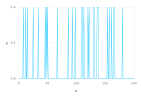

In [114]:
plot(x=1:200, y=int(d[1:200] .> 500), Geom.line)

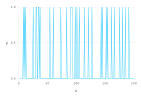

In [198]:
plot(x=1:200, y=int(d3[1:200] .> 500), Geom.line)

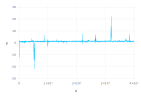

In [100]:
plot(x=1:4000, y=p[1:4000], Geom.line)

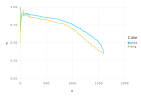

In [24]:
xp,yp = precision_recall(sortrows([-p testLabel])[:,2])
xt,yt = precision_recall(sortrows([-testScore testLabel])[:,2])
plot(x=[xp, xt],y=[yp, yt], color=[["pred" for x in xp], ["orig" for x in xt]], Geom.line)

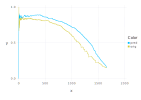

In [66]:
xp,yp = precision_recall(sortrows([-p testLabel])[:,2])
xt,yt = precision_recall(sortrows([-testScore testLabel])[:,2])
plot(x=[xp, xt],y=[yp, yt], color=[["pred" for x in xp], ["orig" for x in xt]], Geom.line)

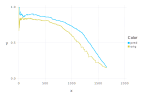

In [58]:
xp,yp = precision_recall(sortrows([-p testLabel])[:,2])
xt,yt = precision_recall(sortrows([-testScore testLabel])[:,2])
plot(x=[xp, xt],y=[yp, yt], color=[["pred" for x in xp], ["orig" for x in xt]], Geom.line)

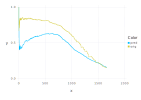

In [25]:
xp,yp = precision_recall(sortrows([p testLabel])[:,2])
xt,yt = precision_recall(sortrows([-testScore testLabel])[:,2])
plot(x=[xp, xt],y=[yp, yt], color=[["pred" for x in xp], ["orig" for x in xt]], Geom.line)

In [241]:
auc(xt,yt)

1124.2500838401045

In [26]:
205504/300000

0.6850133333333334

In [27]:
exp(-0.65)

0.522045776761016

In [29]:
-log(0.52)

0.6539264674066639

In [195]:
d3 = check_scores(p, peaks, motifs)

9594-element Array{Any,1}:
  15483
  18672
  15008
  17675
  13412
  14297
  13138
   6172
  16837
   8754
  11489
   2599
  12300
      ⋮
    603
     10
   6493
     14
 197853
      8
      8
      6
     60
      3
     24
      3

In [197]:
reverse!(d3)

9594-element Array{Any,1}:
      3
     24
      3
     60
      6
      8
      8
 197853
     14
   6493
     10
    603
     17
      ⋮
   2599
  11489
   8754
  16837
   6172
  13138
  14297
  13412
  17675
  15008
  18672
  15483